<a href="https://colab.research.google.com/github/OmerFarooq246/Network-Pruning-of-CNN/blob/main/Network_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# running on 160 by 160 dimension images

# Importing dependencies

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Rescaling, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.models import Model
import os
import csv
import math
import random

# Functions

In [ ]:
#function for displaying given array of images with their true labels and pred labels
def show_imgs(imgs, labels_t, size, cols, labels_f = None, font_size = 10):
  plt.clf()
  plt.figure(figsize = (size[0],size[1]))

  for i in range(len(imgs)):
    plt.subplot(math.ceil(len(imgs)/5),cols,i+1)
    plt.imshow(imgs[i])
    if labels_f is None:
      plt.title("True Label: " + str(labels_t[i]), fontsize = font_size)
    else:
      plt.title("True Label: " + str(labels_t[i]) + "\n" + "Pred Label: " + str(labels_f[i]), fontsize = font_size)
    plt.axis('off')

In [ ]:
#Plot the loss and accuracy curves for training and validation
def acc_loss_plot(m, size = [15,5],los_limit = [0,1], acc_limit = None):
  fig, ax = plt.subplots(1,2, figsize=(size[0],size[1]))
  fig.tight_layout(pad=3)
  ax[0].plot(m.history['loss'], color='b', label="Training loss")
  ax[0].plot(m.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  ax[0].set_ylim([0, 1])
  ax[0].legend()
  ax[0].set_title('Loss plot')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('Loss')

  ax[1].plot(m.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(m.history['val_accuracy'], color='r',label="Validation accuracy")
  # ax[1].set_ylim([0, 1])
  if acc_limit != None:
    ax[1].set_ylim(acc_limit)
  ax[1].legend()
  ax[1].set_title('Accuracy plot')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')

In [ ]:
# function that returns a new network with one filter reduced of the given conv layer
def new_archi(conv_layer, inputshape = None):
  #creating mode
  if(inputshape == None):
    print("input_shape not given")
  else:
    print("input_shape:", inputshape)
  input_shape = inputshape
  aa = 32
  a = 31
  bb = 64
  b = 63
  cc = 128
  c = 127

  input = Input(input_shape, name = "Input_Layer")

  if(conv_layer == 1):
    Conv2D_1 = Conv2D(a, (3,3), (1,1), 'same', name = "Conv2D_1_new")
    Conv2D_2 = Conv2D(bb, (3,3), (1,1), 'same', name = "Conv2D_2_new")
    Conv2D_3 = Conv2D(cc, (3,3), (1,1), 'same', name = "Conv2D_3_new")
    Conv2D_4 = Conv2D(cc, (3,3), (2,2), 'same', name = "Conv2D_4_new")

  elif(conv_layer == 5):
    Conv2D_1 = Conv2D(aa, (3,3), (1,1), 'same', name = "Conv2D_1_new")
    Conv2D_2 = Conv2D(b, (3,3), (1,1), 'same', name = "Conv2D_2_new")
    Conv2D_3 = Conv2D(cc, (3,3), (1,1), 'same', name = "Conv2D_3_new")
    Conv2D_4 = Conv2D(cc, (3,3), (2,2), 'same', name = "Conv2D_4_new")

  elif(conv_layer == 9):
    Conv2D_1 = Conv2D(aa, (3,3), (1,1), 'same', name = "Conv2D_1_new")
    Conv2D_2 = Conv2D(bb, (3,3), (1,1), 'same', name = "Conv2D_2_new")
    Conv2D_3 = Conv2D(c, (3,3), (1,1), 'same', name = "Conv2D_3_new")
    Conv2D_4 = Conv2D(cc, (3,3), (2,2), 'same', name = "Conv2D_4_new")

  elif(conv_layer == 13):
    Conv2D_1 = Conv2D(aa, (3,3), (1,1), 'same', name = "Conv2D_1_new")
    Conv2D_2 = Conv2D(bb, (3,3), (1,1), 'same', name = "Conv2D_2_new")
    Conv2D_3 = Conv2D(cc, (3,3), (1,1), 'same', name = "Conv2D_3_new")
    Conv2D_4 = Conv2D(c, (3,3), (2,2), 'same', name = "Conv2D_4_new")


  x = Conv2D_1(input)
  x = MaxPooling2D((4,4), (2,2), name = "MaxPool_1")(x)
  x = Activation('relu', name = "Relu_1")(x)
  x = BatchNormalization(name = "BatchNorm_1")(x)

  x = Conv2D_2(x)
  x = MaxPooling2D((4,4), (2,2), name = "MaxPool_2")(x)
  x = Activation('relu', name = "Relu_2")(x)
  x = BatchNormalization(name = "BatchNorm_2")(x)

  x = Conv2D_3(x)
  x = MaxPooling2D((4,4), (2,2), name = "MaxPool_3")(x)
  x = Activation('relu', name = "Relu_3")(x)
  x = BatchNormalization(name = "BatchNorm_3")(x)

  x = Conv2D_4(x)
  x = MaxPooling2D((2,2), (2,2), name = "MaxPool_4")(x)
  x = Activation('relu', name = "Relu_4")(x)
  x = BatchNormalization(name = "BatchNorm_4")(x)

  x = Flatten(name = "Flatten_new")(x)
  output = Dense(2, 'softmax', name = "Softmax_new")(x)

  model = Model(inputs = input, outputs = output)

  return model

In [ ]:
def remove_filter(model, layer, filter):
  #getting all the filters of a conv layer
  filters = model.layers[layer].weights
  #deleting a single filter from the filter weights and updating them
  filters[0] = np.delete(filters[0], filter, axis = 3)
  #deleting the bias of the corresponding filter and updating the bias array
  filters[1] = np.delete(filters[1], filter)
  #use set_weights to update filters of the new architecture
  return filters

In [ ]:
def remove_filter_batch(model, layers_filters):
  layer_new_weights = []
  for i in range(len(layers_filters[0])): #accessing layer
    new_weights = model.layers[layers_filters[0][i]].weights
    new_weights[0] = np.delete(new_weights[0], layers_filters[1][i], axis = 3)
    new_weights[1] = np.delete(new_weights[1], layers_filters[1][i])
    layer_new_weights.append(new_weights)

  layer_new_weights = [layers_filters[0], layer_new_weights]
  return layer_new_weights

In [ ]:
#filter here can also mean index
def remove_channel(model, layer, filter):
  filters = model.layers[layer].weights
  filters[0] = np.delete(filters[0], filter, axis = 2)
  return filters

In [ ]:
#filter here can also mean index
def remove_channel_batch(model, layers_channels, custom_weights = None):
  layers_new_channels = []
  if (custom_weights.all() != None):
    temp = custom_weights
    for i in range(len(layers_channels[0])):
      new_channels = temp[1][i]    #accessing layer
      new_channels[0] = np.delete(new_channels[0], layers_channels[1][i], axis = 2)    #removing channels at the provided indexes
      layers_new_channels.append(new_channels)

  else:
    for i in range(len(layers_channels[0])):
      new_channels = model.layers[layers_channels[0][i]].weights    #accessing layer
      new_channels[0] = np.delete(new_channels[0], layers_channels[1][i], axis = 2)    #removing channels at the provided indexes
      layers_new_channels.append(new_channels)

  layers_new_channels = [layers_channels[0], layers_new_channels]
  return layers_new_channels


In [ ]:
def remove_channel_batch_new(model, layers_channels, conv_layer_new_weights):
  # ASSUMING THAT ALL CONV LAYERS HAVE FILTERS TO BE REMOVED AS WELL AS CHANNELS TO REMOVE
  # EXCEPT FOR THE FIRST CONV LAYER WHOSE CHANNELS ARE NOT MEANT TO BE REMOVED

  # for i in range(len(layers_channels[0])):
  #   print(layers_channels[0][i], end = " - ")
  #   print(conv_layer_new_weights[0][i+1])

  temp = np.delete(conv_layer_new_weights, 0, axis = 1)
  layers_new_channels = remove_channel_batch(model, layers_channels, temp)
  return layers_new_channels

In [ ]:
def remove_batchNorm_weights(model, layer, index):
  weights = model.layers[layer].weights
  weights = np.delete(weights, index, axis = 1)
  return weights

In [ ]:
def remove_batchNorm_weights_batch(model, BN_layers_indexes):
  BN_layers_weights = []
  for i in range(len(BN_layers_indexes[0])):
    BN_weights = model.layers[BN_layers_indexes[0][i]].weights
    BN_weights = np.delete(BN_weights, BN_layers_indexes[1][i], axis = 1)
    BN_layers_weights.append(BN_weights)

  BN_layers_weights = [BN_layers_indexes[0], BN_layers_weights]
  return BN_layers_weights

In [ ]:
def remove_dense_weights(model, layer, index, inputshape):
  weights = model.layers[layer].weights
  units = []
  for i in range(weights[0].shape[1]):
    if inputshape == (160,160,3):
      target_shape = (4,4,128)
    elif inputshape == (300,300,3):
      target_shape = (9,9,128)
    temp = tf.reshape(weights[0][:,i], target_shape)
    temp = np.delete(temp, index, axis = 2)
    temp = Flatten()(tf.expand_dims(temp, axis = 0))
    temp = tf.transpose(temp, perm = [1,0])
    units.append(temp)
  weights[0] = concat_elements(units)
  return weights

In [ ]:
def concat_elements(list):
  weights = list[0]
  for i in range(1,len(list)):
    weights = np.concatenate((weights, list[i]), axis = 1)
  return weights

In [ ]:
def prune_one_by_one(model, conv_layers, data, labels, file_name, start = 0, summary = 0, verbose = 0, remove = 1, inputshape = None):
  # if(remove): os.remove("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/record.csv")
  if(remove): os.remove(file_name)
  record = []
  f = open(file_name, "a", newline = '')
  writer = csv.writer(f)
  for i in range(start, len(conv_layers)): #going into a conv layer
    layer = conv_layers[i]
    new_model = new_archi(layer, inputshape = inputshape)
    if(summary): print(new_model.summary())
    print("layer:", layer, end=' ')
    print("(", model.layers[layer].name, ")", sep = '')
    for j in range(model.layers[layer].weights[0].shape[3]): #going into a filter
      print("f[" + str(j) + "]", end = ": ")
      # print("filter_no:", j)

      #remove filter of current conv layer
      filters_1 = remove_filter(model, layer, j)
      # print("filters_1:", filters_1[0].shape)

      #remove filter of next conv layer
      if(layer != conv_layers[-1]):
        filters_2 = remove_channel(model, conv_layers[i+1], j)
        # print("filters_2:", filters_2[0].shape)

      #remove channel of BN_layer
      BN_weights = remove_batchNorm_weights(model, conv_layers[i]+3, j)
      # print("BN_weights:", np.array(BN_weights).shape)

      if(layer == conv_layers[-1]):
        dense_layer = len(model.layers)-1
        dense_weights = remove_dense_weights(model, dense_layer, j, inputshape = inputshape)
        load_weights(model, new_model, layer, batchNorm_layer = conv_layers[i]+3, dense_layer = dense_layer, filters_1 = filters_1, BN_weights = BN_weights, dense_weights = dense_weights)
      else:
        load_weights(model, new_model, layer, conv_layers[i+1], batchNorm_layer = conv_layers[i]+3, filters_1 = filters_1, filters_2 = filters_2, BN_weights = BN_weights)

      new_model.compile(
      loss = keras.losses.BinaryCrossentropy(),
      optimizer = keras.optimizers.Adam(0.001),
      metrics = ["accuracy"]
      )
      eval = new_model.evaluate(data, labels, verbose = verbose)
      # print("eval:", np.around(np.array(eval), 5))
      # print(np.around(np.array(eval), 5))
      print("loss: " + str(round(eval[0], 5)), end = " - ")
      print("accuracy: " + str(round(eval[1],5)))
      record.append([layer, j, eval])
      writer.writerow([layer, j, eval[0], eval[1]])
      # print()
      # if(i == 2):
      #   # return new_model
      #   # f.close()
      #   # return record
      #   break
    print()
  f.close()
  return np.array(record)

In [ ]:
def make_layers_filters(removable_filters, layers):
  #making separate arrays for each layer which will hold the indexes of the filters to be removed
  layers_filters = []
  for i in range(len(layers)):
    layers_filters.append([])

  #if new layer encountered change the index and start populating the new layers's array rahter than the array of the previous layer
  layer = removable_filters[0][0]
  layer_index = 0 #for indexing over the layers_filters array
  for i in range(len(removable_filters)):
    if(removable_filters[i][0] != layer):
      layer = removable_filters[i][0]
      layer_index = layer_index + 1
    #   print("Layer updated:", layer, end = " - ")
    #   print("Layer_index:", layer_index)
    #   print()
    # print("i:",i, end = " - ")
    # print("layer:",layer, end = " - ")
    # print("filter:", removable_filters[i][1])

    layers_filters[layer_index].append(removable_filters[i][1])
  layers_filters = [layers, layers_filters]
  return layers_filters


In [ ]:
# making separate arrays for each layer which will hold the indexes of the channels to be removed
# that depends upon the filters removed from the previous layers
def make_layers_channels(removable_filters, layers, conv_layers):
  layers_channels = []
  for i in range(len(layers)):
    if(layers[i] != conv_layers[-1]):
      layers_channels.append([])
    else:
      continue

  #if new layer encountered change the index and start populating the new layers's array rahter than the array of the previous layer
  layer = removable_filters[0][0]
  layer_index = 0 #for indexing over the layers_channels array
  layers_next = [] #array that will hold layers whos channels are to be removed
  for i in range(len(removable_filters)):
    if(removable_filters[i][0] != layer):
      layers_next.append(layer+4)
      layer = removable_filters[i][0]
      layer_index = layer_index + 1
      # print("Layer updated:", layer, end = " - ")
      # print("Layer_index:", layer_index)
      # print()
    if(layer == conv_layers[-1]):
      continue
    # print("i:",i, end = " - ")
    # print("layer:",layer, end = " - ")
    # print("filter:", removable_filters[i][1])

    layers_channels[layer_index].append(removable_filters[i][1])
  layers_channels = [layers_next, layers_channels]
  return layers_channels



In [ ]:
# making separate arrays for each layer which will hold the indexes of the weights to be removed
# that depends upon the filters removed from the prevois layers
#ASSUMING THAT THERE IS A bn LAYER AFTER EVERY CONV LAYER AND AT THE SAME DISTANCE
def make_BN_layers_indexes(removable_filters, layers):
  BN_layers_indexes = []
  for i in range(len(layers)):
    BN_layers_indexes.append([])

  #if new layer encountered change the index and start populating the new layers's array rahter than the array of the previous layer
  layer = removable_filters[0][0]
  layer_index = 0 #for indexing over the BN_layers_indexes array
  layers_next = [layer+3] #array that will hold BN_layers coming after the conv layers
  for i in range(len(removable_filters)):
    if(removable_filters[i][0] != layer):
      layer = removable_filters[i][0]
      layers_next.append(layer+3)
      layer_index = layer_index + 1
    #   print("Layer updated:", layer, end = " - ")
    #   print("Layer_index:", layer_index)
    #   print()
    # print("i:",i, end = " - ")
    # print("layer:",layer, end = " - ")
    # print("filter:", removable_filters[i][1])

    BN_layers_indexes[layer_index].append(removable_filters[i][1])
  BN_layers_indexes = [layers_next, BN_layers_indexes]
  return BN_layers_indexes


In [ ]:
def make_Dense_indexes(model, layers_filters):
  dense_layer = len(model.layers)-1
  last_conv_layer_filters = layers_filters[1][-1]

  Dense_indexes = [dense_layer, last_conv_layer_filters]
  return Dense_indexes

In [ ]:
def load_weights(model, new_model, layer = None, layer_next = None, batchNorm_layer = None, dense_layer = None, filters_1 = None, filters_2 = None, BN_weights = None, dense_weights = None):
  # print("recieved filters_1:",filters_1[0].shape)
  # print("recieved filters_2:",filters_2[0].shape)
  # print("recieved BN_weights:",np.array(BN_weights).shape)
  # print("recieved dense_weights:",dense_weights[0].shape)
  for i in range(len(model.layers)):
    if(i == layer):
      # print("layer ==", model.layers[i].name)
      # print("expected filters:", new_model.layers[i].weights[0].shape)
      new_model.layers[i].set_weights(filters_1)
    elif(i == layer_next):
      # print("layer ==", model.layers[i].name)
      # print("expected filters:", new_model.layers[i].weights[0].shape)
      new_model.layers[i].set_weights(filters_2)
    elif(i == batchNorm_layer):
      # print("layer ==", model.layers[i].name)
      # print("expected filters:", np.array(new_model.layers[i].weights).shape)
      new_model.layers[i].set_weights(BN_weights)
    elif(i == dense_layer):
      # print("layer ==", model.layers[i].name)
      # print("expected filters:", new_model.layers[i].weights[0].shape)
      new_model.layers[i].set_weights(dense_weights)
    else:
      new_model.layers[i].set_weights(model.layers[i].weights)
  # return new_model

In [ ]:
def delta(original_acc, record, threshold):
  print("original_loss:", round(original_acc[0],5), end = " - ")
  print("original_acc:", round(original_acc[1],5))
  print()
  pos_delta = []
  neg_delta = []
  removable_filters = []
  for i in range(len(record)):
    d = original_acc[1] - record[i][2][1]
    if (d >= threshold):
      pos_delta.append(record[i])
      print("Accuracy decrease", end = " - ")
      print("layer[" + str(record[i][0]) + "]", end = " ")
      print("f[" + str(record[i][1]) + "]", end = ": ")
      print("loss: " + str(round(record[i][2][0], 5)), end = " - ")
      print("accuracy:", round(record[i][2][1],5))
    elif(d < -1*threshold):
      neg_delta.append(record[i])
      print("Accuracy increase", end = " - ")
      print("layer[" + str(record[i][0]) + "]", end = " ")
      print("f[" + str(record[i][1]) + "]", end = ": ")
      print("loss: " + str(round(record[i][2][0], 5)), end = " - ")
      print("accuracy:", round(record[i][2][1],5))
    else:
      print("removeable filter", end = " - ")
      removable_filters.append(record[i])
      print("layer[" + str(record[i][0]) + "]", end = " ")
      print("f[" + str(record[i][1]) + "]", end = ": ")
      print("loss: " + str(round(record[i][2][0], 5)), end = " - ")
      print("accuracy:", round(record[i][2][1],5))
  print("Total filters identified:",len(neg_delta) + len(pos_delta) + len(removable_filters))
  print("Filters increasing accuracy above threshold:", len(neg_delta))
  print("Filters decreasing accuracy above threshold:", len(pos_delta))
  print("Removable filters:", len(removable_filters))
  return np.array(pos_delta), np.array(neg_delta), np.array(removable_filters)

In [ ]:
def prune(model, conv_layers, pos_delta, layers, inputshape):
  layers_filters = make_layers_filters(pos_delta, layers)
  layers_channels = make_layers_channels(pos_delta, layers, conv_layers)
  BN_layers_indexes = make_BN_layers_indexes(pos_delta, layers)
  Dense_indexes = make_Dense_indexes(model, layers_filters)

  conv_layer_new_weights = remove_filter_batch(model, layers_filters)
  layers_new_channels = remove_channel_batch_new(model, layers_channels, conv_layer_new_weights)
  BN_layers_weights = remove_batchNorm_weights_batch(model, BN_layers_indexes)
  Dense_weights = remove_dense_weights(model, Dense_indexes[0], Dense_indexes[1], inputshape = inputshape)

  print(conv_layer_new_weights[0])
  print(layers_new_channels[0])
  print(BN_layers_weights[0])
  print(len(Dense_weights))

  return conv_layer_new_weights, layers_new_channels, BN_layers_weights, Dense_weights

In [ ]:
def new_archi_batch(model, layers, counts):
  md = model.get_config()
  for i in range(len(layers)):
    new_filters = md['layers'][layers[i]]['config']['filters'] - counts[i]
    md['layers'][layers[i]]['config']['filters'] = new_filters

  new_model = Model().from_config(md)
  return new_model

In [ ]:
def load_weights_batch(model, new_model, conv_layer_new_weights, layers_new_channels, BN_layers_weights, dense_layer, Dense_weights):
  first_conv_layer = conv_layer_new_weights[0][0]
  new_model.layers[first_conv_layer].set_weights(conv_layer_new_weights[1][0])

  for i in range(len(layers_new_channels[0])):
    conv_layer = layers_new_channels[0][i]
    weights = layers_new_channels[1][i]
    new_model.layers[conv_layer].set_weights(weights)

  for i in range(len(BN_layers_weights[0])):
    BNN_layer = BN_layers_weights[0][i]
    weights = BN_layers_weights[1][i]
    new_model.layers[BNN_layer].set_weights(weights)

  new_model.layers[dense_layer].set_weights(Dense_weights)


In [ ]:
# tf.keras.backend.clear_session()

# Loading big data

In [ ]:
import tensorflow_datasets as tfds
#loading cats_vs_dogs dataset from tensorflow
dataset_train = tfds.load("cats_vs_dogs", split = 'train[:5000]', as_supervised=True)
dataset_test = tfds.load("cats_vs_dogs", split = 'train[2000:3000]', as_supervised=True)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

5000
1000


In [ ]:
#getting img matrixs and labels of each image
imgs_train_ds = dataset_train.map(lambda images, labels: images)
labels_train_ds = dataset_train.map(lambda images, labels: labels)

imgs_test_ds = dataset_test.map(lambda images, labels: images)
labels_test_ds = dataset_test.map(lambda images, labels: labels)

In [ ]:
#for train images
#getting those images which have minimum 300 by 300 dimensions
#saving the indices of such images to get their corresponding labels
imgs_train_big = []
indexes = []

for i, img in enumerate(imgs_train_ds):
  if(img.shape[0] >= 160 and img.shape[1] >= 160):
    imgs_train_big.append(np.array(img))
    indexes.append(i)

labels_train_big = []
for i in labels_train_ds:
  labels_train_big.append(i)

labels_train_big = np.array(labels_train_big)
labels_train_big = labels_train_big[indexes]

In [ ]:
#for test images
#getting those images which have minimum 300 by 300 dimensions
#saving the indices of such images to get their corresponding labels

imgs_test_big = []
indexes = []

for i, img in enumerate(imgs_test_ds):
  if(img.shape[0] >= 160 and img.shape[1] >= 160):
    imgs_test_big.append(np.array(img))
    indexes.append(i)

labels_test_big = []
for i in labels_test_ds:
  labels_test_big.append(i)

labels_test_big = np.array(labels_test_big)
labels_test_big = labels_test_big[indexes]

In [ ]:
#for train
#resizing all the images to 300 by 300 dimension
for i in range(len(imgs_train_big)):
  imgs_train_big[i] = np.array(tf.image.resize(imgs_train_big[i], [160,160])).astype('uint8')
imgs_train_big = np.array(imgs_train_big)
print(imgs_train_big.shape)

(4800, 160, 160, 3)


In [ ]:
#for test
#resizing all the images to 300 by 300 dimension
for i in range(len(imgs_test_big)):
  imgs_test_big[i] = np.array(tf.image.resize(imgs_test_big[i], [160,160])).astype('uint8')
imgs_test_big = np.array(imgs_test_big)
print(imgs_test_big.shape)

(967, 160, 160, 3)


In [ ]:
print(len(imgs_train_big))
print(len(labels_train_big))
print(len(imgs_test_big))
print(len(labels_test_big))

4800
4800
967
967


In [ ]:
#for train
#creating labels for cats and dogs images
cat_indexes = [] #will store the indices of cat images
dog_indexes = [] #will store the indices of dog images
cats_l =[] #will store the lables of cat images
dogs_l =[] #will store the lables of dog images

for i in range(len(labels_train_big)):
  if labels_train_big[i] == 0:
    cat_indexes.append(i)
    cats_l.append(1)
  else:
    dog_indexes.append(i)
    dogs_l.append(0)

print(len(cat_indexes))
print(len(dog_indexes))

#getting the cat images and dog images
cats = np.array(imgs_train_big)[cat_indexes]
dogs = np.array(imgs_train_big)[dog_indexes]

#combining the cats and dogs images and labels to get single arrays of train images and train labels
imgs_train_big = list(cats[:500]) + list(dogs[:500])
labels_train_big = cats_l[:500] + dogs_l[:500]

2400
2400


In [ ]:
print(len(imgs_train_big))
print(len(labels_train_big))

1000
1000


In [ ]:
#for tet
#creating labels for cats and dogs images
cat_indexes = [] #will store the indices of cat images
dog_indexes = [] #will store the indices of dog images
cats_l =[] #will store the lables of cat images
dogs_l =[] #will store the lables of dog images

for i in range(len(labels_test_big)):
  if labels_test_big[i] == 0:
    cat_indexes.append(i)
    cats_l.append(1)
  else:
    dog_indexes.append(i)
    dogs_l.append(0)

print(len(cat_indexes))
print(len(dog_indexes))

#getting the cat images and dog images
cats = np.array(imgs_test_big)[cat_indexes]
dogs = np.array(imgs_test_big)[dog_indexes]

#combining the cats and dogs images and labels to get single arrays of train images and train labels
imgs_test_big = list(cats[:100]) + list(dogs[:100])
labels_test_big = cats_l[:100] + dogs_l[:100]

466
501


In [ ]:
print(len(imgs_test_big))
print(len(labels_test_big))

200
200


In [ ]:
#shuffling the train and test arrays
indices = np.arange(len(imgs_train_big))
np.random.shuffle(indices)
imgs_train_big = np.array(imgs_train_big)[indices]
labels_train_big = np.array(labels_train_big)[indices]

indices = np.arange(len(imgs_test_big))
np.random.shuffle(indices)
imgs_test_big = np.array(imgs_test_big)[indices]
labels_test_big = np.array(labels_test_big)[indices]

In [ ]:
print(imgs_train_big.shape)
print(labels_train_big.shape)
print(imgs_test_big.shape)
print(labels_test_big.shape)

(1000, 160, 160, 3)
(1000,)
(200, 160, 160, 3)
(200,)


In [ ]:
#creating one hot vectors of labels of train and test
labels_train_new_big = []
for i in range(len(labels_train_big)):
  if labels_train_big[i] == 0:
    labels_train_new_big.append([0,1])
  else:
    labels_train_new_big.append([1,0])

labels_train_new_big = np.array(labels_train_new_big)

labels_test_new_big = []
for i in range(len(labels_test_big)):
  if labels_test_big[i] == 0:
    labels_test_new_big.append([0,1])
  else:
    labels_test_new_big.append([1,0])

labels_test_new_big = np.array(labels_test_new_big)

<Figure size 640x480 with 0 Axes>

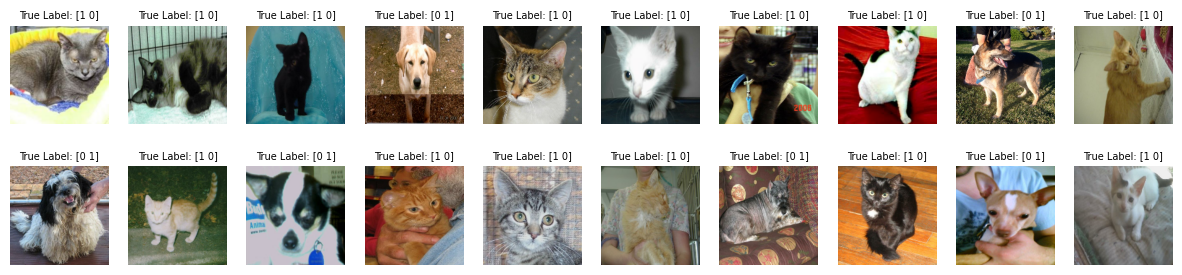

In [ ]:
show_imgs(imgs_train_big[:20], labels_train_new_big[:20], [15,7], 10, font_size = 7)

<Figure size 640x480 with 0 Axes>

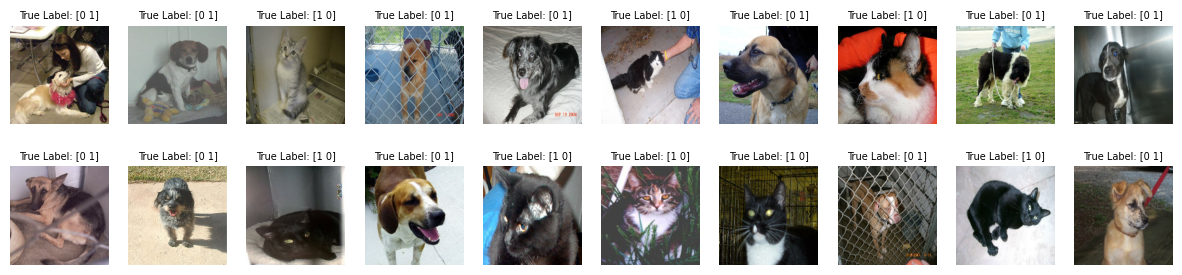

In [ ]:
show_imgs(imgs_test_big[:20], labels_test_new_big[:20], [15,7], 10, font_size = 7)

# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [ ]:
#loading data
train_ds = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/images_train.npy")
test_ds = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/images_test.npy")
cv_ds = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/images_valid.npy")

labels_train = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/labels_train.npy")
labels_test = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/labels_test.npy")
labels_cv = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/labels_valid.npy")

In [ ]:
test_ds.shape

(300, 160, 160, 3)

In [ ]:
labels_train_new = []
for i in range(len(labels_train)):
  if labels_train[i] == 0:
    labels_train_new.append([0,1])
  else:
    labels_train_new.append([1,0])

labels_train_new = np.array(labels_train_new)

labels_cv_new = []
for i in range(len(labels_cv)):
  if labels_cv[i] == 0:
    labels_cv_new.append([0,1])
  else:
    labels_cv_new.append([1,0])

labels_cv_new = np.array(labels_cv_new)


labels_test_new = []
for i in range(len(labels_test)):
  if labels_test[i] == 0:
    labels_test_new.append([0,1])
  else:
    labels_test_new.append([1,0])

labels_test_new = np.array(labels_test_new)

# Making a basic  CNN Model (res: 300 by 300)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
#seeting seed for uniform randomization
tf.random.set_seed(231)

In [ ]:
#creating model
input_shape = (160,160,3)
# input_shape = (300,300,3)
initial_filters = 32

input = Input(input_shape, name = "Input_Layer")

x = Conv2D(32, (3,3), (1,1), 'same', name = "Conv2D_1")(input)
x = MaxPooling2D((4,4), (2,2), name = "MaxPool_1")(x)
x = Activation('relu', name = "Relu_1")(x)
x = BatchNormalization(name = "BatchNorm_1")(x)

x = Conv2D(32*2, (3,3), (1,1), 'same', name = "Conv2D_2")(x)
x = MaxPooling2D((4,4), (2,2), name = "MaxPool_2")(x)
x = Activation('relu', name = "Relu_2")(x)
x = BatchNormalization(name = "BatchNorm_2")(x)

x = Conv2D(32*4, (3,3), (1,1), 'same', name = "Conv2D_3")(x)
x = MaxPooling2D((4,4), (2,2), name = "MaxPool_3")(x)
x = Activation('relu', name = "Relu_3")(x)
x = BatchNormalization(name = "BatchNorm_3")(x)

x = Conv2D(32*4, (3,3), (2,2), 'same', name = "Conv2D_4")(x)
x = MaxPooling2D((2,2), (2,2), name = "MaxPool_4")(x)
x = Activation('relu', name = "Relu_4")(x)
x = BatchNormalization(name = "BatchNorm_4")(x)

x = Flatten(name = "Flatten")(x)

output = Dense(2, 'softmax', name = "Softmax")(x)

model = Model(inputs = input, outputs = output)

In [ ]:
model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 79, 79, 32)        0         
                                                                 
 Relu_1 (Activation)         (None, 79, 79, 32)        0         
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 79, 79, 32)       128       
 tion)                                                           
                                                                 
 Conv2D_2 (Conv2D)           (None, 79, 79, 64)        18496     
                                                             

In [ ]:
# tf.keras.utils.plot_model(model)

## Training the model

In [ ]:
train_control = 1

callback2 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1, mode = 'min', min_lr = 0.000001)

In [ ]:
if (train_control):
  m = model.fit(train_ds, labels_train_new, validation_data = (cv_ds, labels_cv_new), epochs = 10, batch_size = 64, callbacks = callback2)
  # m = model.fit(imgs_train_big, labels_train_new_big, validation_data = (imgs_test_big, labels_test_new_big), epochs = 10, batch_size = 64, callbacks = callback2)

Epoch 1/10
10/10 [==============================] - 17s 304ms/step - loss: 0.8201 - accuracy: 0.5600 - val_loss: 1.2263 - val_accuracy: 0.5633 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 100ms/step - loss: 0.5068 - accuracy: 0.7733 - val_loss: 2.0314 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 104ms/step - loss: 0.3714 - accuracy: 0.8850 - val_loss: 0.8686 - val_accuracy: 0.6133 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 1s 102ms/step - loss: 0.3475 - accuracy: 0.9033 - val_loss: 0.7223 - val_accuracy: 0.6533 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 1s 104ms/step - loss: 0.3194 - accuracy: 0.9150 - val_loss: 0.6844 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 1s 73ms/step - loss: 0.2945 - accuracy: 0.9350 - val_loss: 0.6575 - val_accuracy: 0.6733 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - 1s

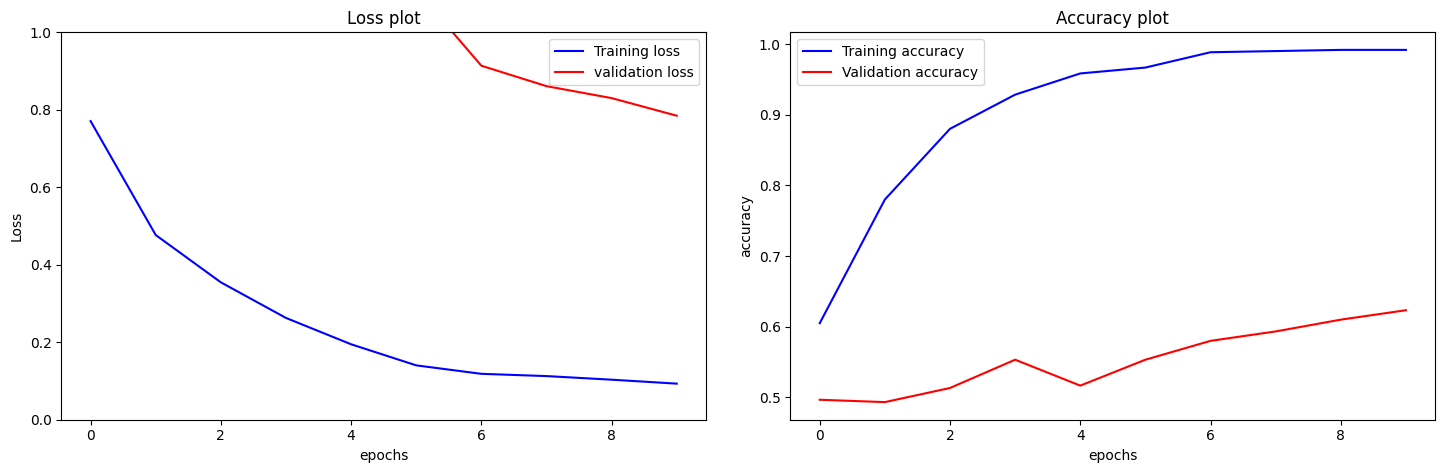

In [ ]:
acc_loss_plot(m)

In [ ]:
# weights = "/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/model_weights/weights_pruning_big.h5"
weights = "/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/model_weights/weights_pruning.h5"
model.save_weights(weights)
model.load_weights(weights)

In [ ]:
conv_layers = []
for i in range(len(model.layers)):
  if(model.layers[i].__class__ == Conv2D):
    conv_layers.append(i)
print(conv_layers)
print()
for i in conv_layers:
  print(model.layers[i].name, end = ": ")
  print(model.layers[i].weights[0].shape)

[1, 5, 9, 13]

Conv2D_1: (3, 3, 3, 32)
Conv2D_2: (3, 3, 32, 64)
Conv2D_3: (3, 3, 64, 128)
Conv2D_4: (3, 3, 128, 128)


# Pruning the model one filter a time

In [ ]:
original_acc = model.evaluate(cv_ds, labels_cv_new)
# original_acc = model.evaluate(imgs_test_big, labels_test_new_big)

10/10 [==============================] - 1s 42ms/step - loss: 0.6069 - accuracy: 0.6733


In [ ]:
file_name = "/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/record_big.csv"
# file_name = "/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/record.csv"
record = prune_one_by_one(model, conv_layers, cv_ds, labels_cv_new, file_name, start = 0, summary = 1, verbose = 0, remove = 1, inputshape = (160,160,3))
# record = prune_one_by_one(model, conv_layers, imgs_test_big, labels_test_new_big, file_name, start = 0, summary = 1, verbose = 0, remove = 1, inputshape = (160,160,3))

input_shape: (160, 160, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 Conv2D_1_new (Conv2D)       (None, 160, 160, 31)      868       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 79, 79, 31)        0         
                                                                 
 Relu_1 (Activation)         (None, 79, 79, 31)        0         
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 79, 79, 31)       124       
 tion)                                                           
                                                                 
 Conv2D_2_new (Conv2D)       (None, 79, 79, 64)        17920     
                                

<ipython-input-14-3f9ef7e27046>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(record)


In [ ]:
# np.save("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/record.npy", record)
record = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/record.npy", allow_pickle=True)

In [ ]:
pos_delta, neg_delta, removable_filters = delta(original_acc, record, 0.005)

original_loss: 0.60686 - original_acc: 0.67333

Accuracy increase - layer[1] f[0]: loss: 0.60034 - accuracy: 0.68667
Accuracy decrease - layer[1] f[1]: loss: 0.60537 - accuracy: 0.66333
removeable filter - layer[1] f[2]: loss: 0.60672 - accuracy: 0.67333
Accuracy decrease - layer[1] f[3]: loss: 0.61095 - accuracy: 0.66
Accuracy decrease - layer[1] f[4]: loss: 0.61197 - accuracy: 0.66
Accuracy decrease - layer[1] f[5]: loss: 0.60842 - accuracy: 0.66667
Accuracy decrease - layer[1] f[6]: loss: 0.62031 - accuracy: 0.64333
Accuracy decrease - layer[1] f[7]: loss: 0.61653 - accuracy: 0.65667
removeable filter - layer[1] f[8]: loss: 0.60578 - accuracy: 0.67667
removeable filter - layer[1] f[9]: loss: 0.59714 - accuracy: 0.67
removeable filter - layer[1] f[10]: loss: 0.60694 - accuracy: 0.67333
removeable filter - layer[1] f[11]: loss: 0.60972 - accuracy: 0.67
Accuracy increase - layer[1] f[12]: loss: 0.60328 - accuracy: 0.69333
Accuracy increase - layer[1] f[13]: loss: 0.61171 - accuracy: 0.

In [ ]:
print(len(neg_delta))
print(len(pos_delta))
print(len(removable_filters))
print("total filters in model:", 32 + 64 + 128*2)

66
71
215
total filters in model: 352


In [ ]:
print(neg_delta[:,0])
print(pos_delta[:,0])
print(removable_filters[:,0])

[1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13]
[1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13]
[1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]


In [ ]:
layers_n, counts_n = np.unique(neg_delta[:,0], return_counts=True)
print(layers_n)
print(counts_n)
print()

layers_p, counts_p = np.unique(pos_delta[:,0], return_counts=True)
print(layers_p)
print(counts_p)
print()

layers_r, counts_r = np.unique(removable_filters[:,0], return_counts=True)
print(layers_r)
print(counts_r)
print()

[1 5 9 13]
[ 8 15 21 22]

[1 5 9 13]
[13 16 17 25]

[1 5 9 13]
[11 33 90 81]



# Making array of filters corresponding to each layers that are to be removed

In [ ]:
layers_filters_neg = make_layers_filters(neg_delta, layers_n)
layers_filters_pos = make_layers_filters(pos_delta, layers_p)
layers_filters_remove = make_layers_filters(removable_filters, layers_r)

In [ ]:
for i in layers_filters_remove[1]:
  print("total filters:", len(i), end = " - ")
  print(i)

total filters: 11 - [2, 8, 9, 10, 11, 15, 18, 22, 26, 28, 31]
total filters: 33 - [1, 2, 3, 6, 7, 10, 11, 14, 15, 16, 23, 25, 29, 31, 35, 36, 38, 39, 40, 41, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 56, 57, 59]
total filters: 90 - [0, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 18, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 42, 44, 45, 48, 51, 52, 53, 54, 55, 57, 58, 61, 62, 64, 66, 68, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 117, 118, 119, 121, 122, 125, 126, 127]
total filters: 81 - [2, 4, 5, 6, 8, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 40, 42, 43, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 69, 71, 77, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 98, 99, 102, 103, 105, 106, 108, 109, 112, 113, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [ ]:
#first index: if 0: access the layers array
# if 1: access the filters of a layer layer
# second index: allow us to access the layers and their filters one by one, must be of same value for every value of the first index
print("all layers in layers_filters:", layers_filters_remove[0])
print(layers_filters_remove[0][0])
print(layers_filters_remove[1][0])

all layers in layers_filters: [1 5 9 13]
1
[2, 8, 9, 10, 11, 15, 18, 22, 26, 28, 31]


# Making array of channels corresponding to each layers that are to be removed

In [ ]:
layers_channels_neg = make_layers_channels(neg_delta, layers_n, conv_layers)
layers_channels_pos = make_layers_channels(pos_delta, layers_p, conv_layers)
layers_channels_remove = make_layers_channels(removable_filters, layers_r, conv_layers)

In [ ]:
layers_channels_neg[0]

[5, 9, 13]

In [ ]:
for i in layers_channels_neg[1]:
  print("total channels:", len(i), end = " - ")
  print(i)

total channels: 8 - [0, 12, 13, 14, 16, 19, 23, 29]
total channels: 15 - [0, 9, 12, 13, 17, 18, 22, 24, 28, 32, 46, 51, 58, 60, 61]
total channels: 21 - [3, 10, 20, 22, 34, 43, 46, 47, 50, 56, 60, 63, 69, 75, 87, 93, 103, 106, 120, 123, 124]


In [ ]:
for i in layers_channels_remove[1]:
  print("total channels:", len(i), end = " - ")
  print(i)

total channels: 11 - [2, 8, 9, 10, 11, 15, 18, 22, 26, 28, 31]
total channels: 33 - [1, 2, 3, 6, 7, 10, 11, 14, 15, 16, 23, 25, 29, 31, 35, 36, 38, 39, 40, 41, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 56, 57, 59]
total channels: 90 - [0, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 18, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 42, 44, 45, 48, 51, 52, 53, 54, 55, 57, 58, 61, 62, 64, 66, 68, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 117, 118, 119, 121, 122, 125, 126, 127]


In [ ]:
layers_channels_remove[0]

[5, 9, 13]

In [ ]:
#first index: if 0: access the layers array
# if 1: access the channels of a layer layer
# second index: allow us to access the layers and their filters one by one, must be of same value for every value of the first index
print(layers_channels_remove[0][0])
print(layers_channels_remove[1][0])

5
[2, 8, 9, 10, 11, 15, 18, 22, 26, 28, 31]


# Making array of weights of BN_Layers corresponding to each filter that is to be removed

In [ ]:
BN_layers_indexes_neg = make_layers_filters(neg_delta, layers_n)
BN_layers_indexes_pos = make_layers_filters(pos_delta, layers_p)
BN_layers_indexes_remove = make_BN_layers_indexes(removable_filters, layers_r)

In [ ]:
for i in BN_layers_indexes_remove[1]:
  print("total channels:", len(i), end = " - ")
  print(i)

total channels: 11 - [2, 8, 9, 10, 11, 15, 18, 22, 26, 28, 31]
total channels: 33 - [1, 2, 3, 6, 7, 10, 11, 14, 15, 16, 23, 25, 29, 31, 35, 36, 38, 39, 40, 41, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 56, 57, 59]
total channels: 90 - [0, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 18, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 42, 44, 45, 48, 51, 52, 53, 54, 55, 57, 58, 61, 62, 64, 66, 68, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 117, 118, 119, 121, 122, 125, 126, 127]
total channels: 81 - [2, 4, 5, 6, 8, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 40, 42, 43, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 69, 71, 77, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 98, 99, 102, 103, 105, 106, 108, 109, 112, 113, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [ ]:
BN_layers_indexes_remove[0]

[4, 8, 12, 16]

In [ ]:
#first index: if 0: access the layers array
# if 1: access the filters of a layer layer
# second index: allow us to access the layers and their filters one by one, must be of same value for every value of the first index
print(BN_layers_indexes_remove[0][0])
print(BN_layers_indexes_remove[1][0])

4
[2, 8, 9, 10, 11, 15, 18, 22, 26, 28, 31]


# Making array of weights of Dense layere to be removed depending upon the filters removed form the last conv layer

In [ ]:
print(layers_filters_remove[0][-1])
print(layers_filters_remove[1][-1])

13
[2, 4, 5, 6, 8, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 40, 42, 43, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 69, 71, 77, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 98, 99, 102, 103, 105, 106, 108, 109, 112, 113, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [ ]:
Dense_indexes = make_Dense_indexes(model, layers_filters_remove)

In [ ]:
print(Dense_indexes)

[18, [2, 4, 5, 6, 8, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 40, 42, 43, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 69, 71, 77, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 98, 99, 102, 103, 105, 106, 108, 109, 112, 113, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]]


# Pruning the complete model

In [ ]:
conv_layer_new_weights_n, layers_new_channels_n, BN_layers_weights_n, Dense_weights_n = prune(model, conv_layers, neg_delta, layers_n, inputshape = input_shape)
print()
conv_layer_new_weights_p, layers_new_channels_p, BN_layers_weights_p, Dense_weights_p = prune(model, conv_layers, pos_delta, layers_p, inputshape = input_shape)
print()
conv_layer_new_weights_r, layers_new_channels_r, BN_layers_weights_r, Dense_weights_r = prune(model, conv_layers, removable_filters, layers_r, inputshape = input_shape)

[1 5 9 13]
[5, 9, 13]
[4, 8, 12, 16]
2

[1 5 9 13]
[5, 9, 13]
[4, 8, 12, 16]
2

[1 5 9 13]
[5, 9, 13]
[4, 8, 12, 16]
2


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
# layers_n = np.concatenate((np.array(conv_layer_new_weights_n[0]), np.array(layers_new_channels_n[0]),
#                            np.array(BN_layers_weights_n[0]), np.array([dense_layer])), axis = 0)

# u_layers_n = list(np.unique(layers_n))
# d_layers_n = list(np.arange(0,len(model.layers_n)))
# d_layers_n = list(set(d_layers_n) - set(u_layers_n))

# print(u_layers)
# print(d_layers)

In [ ]:
# counts

array([ 8, 10,  2,  8])

In [ ]:
# for i in layers_new_channels_r[1]:
#   print(i[0].shape)

(3, 3, 24, 54)
(3, 3, 54, 126)
(3, 3, 126, 120)


# Loading pruned weights in new architecture

In [ ]:
#making three models out of which neg_delta, pos_delta and removeable layers will be removed separately
#one tripple for fine tune at low lr and one tripple at high lr
new_model_n_low = new_archi_batch(model, layers_n, counts_n)
new_model_p_low = new_archi_batch(model, layers_p, counts_p)
new_model_r_low = new_archi_batch(model, layers_r, counts_r)

new_model_n_low.summary()
print()
new_model_p_low.summary()
print()
new_model_r_low.summary()
print()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 160, 160, 24)      672       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 79, 79, 24)        0         
                                                                 
 Relu_1 (Activation)         (None, 79, 79, 24)        0         
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 79, 79, 24)       96        
 tion)                                                           
                                                                 
 Conv2D_2 (Conv2D)           (None, 79, 79, 49)        10633     
                                                             

In [ ]:
#making high lr models
new_model_n_high = new_archi_batch(model, layers_n, counts_n)
new_model_p_high = new_archi_batch(model, layers_p, counts_p)
new_model_r_high = new_archi_batch(model, layers_r, counts_r)
#summarys same as above models

In [ ]:
#testing the low lr models
load_weights_batch(model, new_model_n_low, conv_layer_new_weights_n, layers_new_channels_n, BN_layers_weights_n, len(model.layers)-1, Dense_weights_n)
load_weights_batch(model, new_model_p_low, conv_layer_new_weights_p, layers_new_channels_p, BN_layers_weights_p, len(model.layers)-1, Dense_weights_p)
load_weights_batch(model, new_model_r_low, conv_layer_new_weights_r, layers_new_channels_r, BN_layers_weights_r, len(model.layers)-1, Dense_weights_r)

In [ ]:
new_model_n_low.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

new_model_p_low.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

new_model_r_low.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

print(new_model_n_low.evaluate(cv_ds, labels_cv_new))
print(new_model_p_low.evaluate(cv_ds, labels_cv_new))
print(new_model_r_low.evaluate(cv_ds, labels_cv_new))

# print(new_model_n_low.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_p_low.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_r_low.evaluate(imgs_test_big, labels_test_new_big))

10/10 [==============================] - 1s 39ms/step - loss: 0.7674 - accuracy: 0.5400
[0.7673768997192383, 0.5400000214576721]
10/10 [==============================] - 1s 36ms/step - loss: 0.7526 - accuracy: 0.5500
[0.7525946497917175, 0.550000011920929]
10/10 [==============================] - 1s 30ms/step - loss: 0.7011 - accuracy: 0.4967
[0.7010964751243591, 0.49666666984558105]


#Fine Tuning

In [ ]:
callback2 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1, mode = 'min', min_lr = 0.000001)

In [ ]:
new_model_n_low.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(1e-5),
    metrics = ["accuracy"]
  )

new_m_n = new_model_n_low.fit(train_ds, labels_train_new, validation_data = (cv_ds, labels_cv_new), epochs = 10, batch_size = 64, callbacks = callback2)
# new_m_n = new_model_n_low.fit(imgs_train_big, labels_train_new_big, validation_data = (imgs_test_big, labels_test_new_big), epochs = 10, batch_size = 64, callbacks = callback2)

Epoch 1/10
10/10 [==============================] - 10s 255ms/step - loss: 0.5219 - accuracy: 0.7450 - val_loss: 0.7299 - val_accuracy: 0.5433 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - 1s 68ms/step - loss: 0.4999 - accuracy: 0.7667 - val_loss: 0.7009 - val_accuracy: 0.5567 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - 1s 71ms/step - loss: 0.4792 - accuracy: 0.7983 - val_loss: 0.6793 - val_accuracy: 0.5767 - lr: 1.0000e-05
Epoch 4/10
10/10 [==============================] - 1s 98ms/step - loss: 0.4598 - accuracy: 0.8050 - val_loss: 0.6615 - val_accuracy: 0.6233 - lr: 1.0000e-05
Epoch 5/10
10/10 [==============================] - 1s 64ms/step - loss: 0.4438 - accuracy: 0.8300 - val_loss: 0.6479 - val_accuracy: 0.6433 - lr: 1.0000e-05
Epoch 6/10
10/10 [==============================] - 1s 63ms/step - loss: 0.4363 - accuracy: 0.8333 - val_loss: 0.6380 - val_accuracy: 0.6533 - lr: 1.0000e-05
Epoch 7/10
10/10 [==============================] 

In [ ]:
new_model_p_low.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(1e-5),
    metrics = ["accuracy"]
  )

new_m_p = new_model_p_low.fit(train_ds, labels_train_new, validation_data = (cv_ds, labels_cv_new), epochs = 10, batch_size = 64, callbacks = callback2)
# new_m_p = new_model_p_low.fit(imgs_train_big, labels_train_new_big, validation_data = (imgs_test_big, labels_test_new_big), epochs = 10, batch_size = 64, callbacks = callback2)

Epoch 1/10
10/10 [==============================] - 14s 181ms/step - loss: 0.5187 - accuracy: 0.7583 - val_loss: 0.7232 - val_accuracy: 0.5733 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - 1s 55ms/step - loss: 0.5099 - accuracy: 0.7583 - val_loss: 0.7030 - val_accuracy: 0.6067 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - 1s 55ms/step - loss: 0.4863 - accuracy: 0.7600 - val_loss: 0.6885 - val_accuracy: 0.6000 - lr: 1.0000e-05
Epoch 4/10
10/10 [==============================] - 1s 60ms/step - loss: 0.4688 - accuracy: 0.8017 - val_loss: 0.6776 - val_accuracy: 0.6100 - lr: 1.0000e-05
Epoch 5/10
10/10 [==============================] - 1s 60ms/step - loss: 0.4572 - accuracy: 0.7917 - val_loss: 0.6693 - val_accuracy: 0.6167 - lr: 1.0000e-05
Epoch 6/10
10/10 [==============================] - 1s 55ms/step - loss: 0.4506 - accuracy: 0.8017 - val_loss: 0.6621 - val_accuracy: 0.6233 - lr: 1.0000e-05
Epoch 7/10
10/10 [==============================] 

In [ ]:
new_model_r_low.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(1e-5),
    metrics = ["accuracy"]
  )

new_m_r = new_model_r_low.fit(train_ds, labels_train_new, validation_data = (cv_ds, labels_cv_new), epochs = 10, batch_size = 64, callbacks = callback2)
# new_m_r = new_model_r_low.fit(imgs_train_big, labels_train_new_big, validation_data = (imgs_test_big, labels_test_new_big), epochs = 10, batch_size = 64, callbacks = callback2)

Epoch 1/10
10/10 [==============================] - 6s 138ms/step - loss: 0.6272 - accuracy: 0.6867 - val_loss: 0.6987 - val_accuracy: 0.4967 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - 0s 47ms/step - loss: 0.6152 - accuracy: 0.7033 - val_loss: 0.6957 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - 0s 45ms/step - loss: 0.6088 - accuracy: 0.7233 - val_loss: 0.6924 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/10
10/10 [==============================] - 0s 51ms/step - loss: 0.6043 - accuracy: 0.7333 - val_loss: 0.6889 - val_accuracy: 0.5033 - lr: 1.0000e-05
Epoch 5/10
10/10 [==============================] - 0s 45ms/step - loss: 0.5944 - accuracy: 0.7283 - val_loss: 0.6855 - val_accuracy: 0.5033 - lr: 1.0000e-05
Epoch 6/10
10/10 [==============================] - 0s 46ms/step - loss: 0.5890 - accuracy: 0.7550 - val_loss: 0.6819 - val_accuracy: 0.5167 - lr: 1.0000e-05
Epoch 7/10
10/10 [==============================] -

In [ ]:
# acc_loss_plot(new_m)

In [ ]:
print(model.evaluate(test_ds, labels_test_new))
print(new_model_n_low.evaluate(test_ds, labels_test_new))
print(new_model_p_low.evaluate(test_ds, labels_test_new))
print(new_model_r_low.evaluate(test_ds, labels_test_new))

# print(model.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_n_low.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_p_low.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_r_low.evaluate(imgs_test_big, labels_test_new_big))

10/10 [==============================] - 0s 17ms/step - loss: 0.6273 - accuracy: 0.6733
[0.6273496747016907, 0.6733333468437195]
10/10 [==============================] - 0s 17ms/step - loss: 0.6393 - accuracy: 0.6500
[0.6393101215362549, 0.6499999761581421]
10/10 [==============================] - 0s 14ms/step - loss: 0.6255 - accuracy: 0.6933
[0.6254875063896179, 0.6933333277702332]
10/10 [==============================] - 0s 14ms/step - loss: 0.6604 - accuracy: 0.5633
[0.6603780388832092, 0.5633333325386047]


# EXP Fine Tuning

In [ ]:
new_model_n_high.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

new_m_n = new_model_n_high.fit(train_ds, labels_train_new, validation_data = (cv_ds, labels_cv_new), epochs = 10, batch_size = 64, callbacks = callback2)
# new_m_n = new_model_n_high.fit(imgs_train_big, labels_train_new_big, validation_data = (imgs_test_big, labels_test_new_big), epochs = 10, batch_size = 64, callbacks = callback2)

Epoch 1/10
10/10 [==============================] - 8s 134ms/step - loss: 0.7416 - accuracy: 0.6133 - val_loss: 1.0561 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 74ms/step - loss: 0.4177 - accuracy: 0.8083 - val_loss: 0.9387 - val_accuracy: 0.6033 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 76ms/step - loss: 0.2842 - accuracy: 0.9150 - val_loss: 0.8135 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 1s 87ms/step - loss: 0.2096 - accuracy: 0.9567 - val_loss: 0.8280 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 1s 99ms/step - loss: 0.1477 - accuracy: 0.9867 - val_loss: 0.7151 - val_accuracy: 0.6133 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 1s 74ms/step - loss: 0.1298 - accuracy: 0.9950 - val_loss: 0.6807 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - 1s 68ms/step - 

In [ ]:
new_model_p_high.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

new_m_p = new_model_p_high.fit(train_ds, labels_train_new, validation_data = (cv_ds, labels_cv_new), epochs = 10, batch_size = 64, callbacks = callback2)
# new_m_p = new_model_p_high.fit(imgs_train_big, labels_train_new_big, validation_data = (imgs_test_big, labels_test_new_big), epochs = 10, batch_size = 64, callbacks = callback2)

Epoch 1/10
10/10 [==============================] - 7s 99ms/step - loss: 0.8178 - accuracy: 0.5800 - val_loss: 0.8867 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 56ms/step - loss: 0.4447 - accuracy: 0.8083 - val_loss: 1.1706 - val_accuracy: 0.6067 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 60ms/step - loss: 0.3319 - accuracy: 0.8950 - val_loss: 0.8033 - val_accuracy: 0.6233 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 1s 60ms/step - loss: 0.3012 - accuracy: 0.9117 - val_loss: 0.7953 - val_accuracy: 0.5633 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 1s 60ms/step - loss: 0.2800 - accuracy: 0.9250 - val_loss: 0.7727 - val_accuracy: 0.5633 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 1s 56ms/step - loss: 0.2588 - accuracy: 0.9433 - val_loss: 0.7157 - val_accuracy: 0.5867 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - 1s 61ms/

In [ ]:
new_model_r_high.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

new_m_r = new_model_r_high.fit(train_ds, labels_train_new, validation_data = (cv_ds, labels_cv_new), epochs = 10, batch_size = 64, callbacks = callback2)
# new_m_r = new_model_r_high.fit(imgs_train_big, labels_train_new_big, validation_data = (imgs_test_big, labels_test_new_big), epochs = 10, batch_size = 64, callbacks = callback2)

Epoch 1/10
10/10 [==============================] - 5s 106ms/step - loss: 0.7739 - accuracy: 0.5517 - val_loss: 2.9000 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 0s 46ms/step - loss: 0.5768 - accuracy: 0.7250 - val_loss: 1.3096 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 52ms/step - loss: 0.4753 - accuracy: 0.8350 - val_loss: 1.0043 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 0s 45ms/step - loss: 0.4001 - accuracy: 0.8667 - val_loss: 0.9509 - val_accuracy: 0.5100 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 1s 52ms/step - loss: 0.3329 - accuracy: 0.9000 - val_loss: 0.7196 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 0s 47ms/step - loss: 0.2681 - accuracy: 0.9333 - val_loss: 0.6749 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 0s 51ms/step - loss: 0.

In [ ]:
new_model_n_high.summary()
new_model_p_high.summary()
new_model_r_high.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 160, 160, 24)      672       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 79, 79, 24)        0         
                                                                 
 Relu_1 (Activation)         (None, 79, 79, 24)        0         
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 79, 79, 24)       96        
 tion)                                                           
                                                                 
 Conv2D_2 (Conv2D)           (None, 79, 79, 49)        10633     
                                                             

In [ ]:
print(model.evaluate(test_ds, labels_test_new))
print(new_model_n_high.evaluate(test_ds, labels_test_new))
print(new_model_p_high.evaluate(test_ds, labels_test_new))
print(new_model_r_high.evaluate(test_ds, labels_test_new))

# print(model.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_n_high.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_p_high.evaluate(imgs_test_big, labels_test_new_big))
# print(new_model_r_high.evaluate(imgs_test_big, labels_test_new_big))

10/10 [==============================] - 0s 17ms/step - loss: 0.6273 - accuracy: 0.6733
[0.6273496747016907, 0.6733333468437195]
10/10 [==============================] - 0s 15ms/step - loss: 0.6504 - accuracy: 0.6267
[0.6503685116767883, 0.6266666650772095]
10/10 [==============================] - 0s 14ms/step - loss: 0.6715 - accuracy: 0.6633
[0.6714556813240051, 0.6633333563804626]
10/10 [==============================] - 0s 11ms/step - loss: 0.6915 - accuracy: 0.6167
[0.6915047764778137, 0.6166666746139526]


In [ ]:
# #saving models
# high_path = "/content/drive/MyDrive/Network Pruning/300 by 300 big/High_lr"
# low_path = "/content/drive/MyDrive/Network Pruning/300 by 300 big/Low_lr"

# new_model_n_low.save(low_path + "/n.h5")
# new_model_p_low.save(low_path + "/p.h5")
# new_model_r_low.save(low_path + "/r.h5")

# model.save("/content/drive/MyDrive/Network Pruning/300 by 300 big/model.h5")
# new_model_n_high.save(high_path + "/n.h5")
# new_model_p_high.save(low_path + "/p.h5")
# new_model_r_high.save(low_path + "/p.h5")

In [ ]:
print(model.layers[13].weights[0].shape)

print(model.layers[4].weights[0].name)
print(model.layers[4].weights[1].name)
print(model.layers[4].weights[2].name)
print(model.layers[4].weights[3].name)

print(model.layers[4].weights[0].shape)
print(model.layers[4].weights[1].shape)
print(model.layers[4].weights[2].shape)
print(model.layers[4].weights[3].shape)

(3, 3, 128, 128)
BatchNorm_1/gamma:0
BatchNorm_1/beta:0
BatchNorm_1/moving_mean:0
BatchNorm_1/moving_variance:0
(32,)
(32,)
(32,)
(32,)


# Extra

In [ ]:
z = remove_dense_weights(model, 18, 0)

In [ ]:
weights[0][:126] == model.layers[-1].weights[0][1:127]

In [ ]:
weights[0][0:126,0] == model.layers[-1].weights[0][1:127,0]

<tf.Tensor: shape=(126,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  Tr

In [ ]:
a = tf.reshape(w[0][:,0], (4,4,128))
b = tf.reshape(w[0][:,1], (4,4,128))
print(a.shape)
print(b.shape)

(4, 4, 128)
(4, 4, 128)


In [ ]:
a = np.delete(a, 0, axis = 2)
b = np.delete(b, 0, axis = 2)
print(a.shape)
print(b.shape)

(4, 4, 127)
(4, 4, 127)


In [ ]:
a = Flatten()(tf.expand_dims(a,axis = 0))
b = Flatten()(tf.expand_dims(b,axis = 0))
print(a.shape)
print(b.shape)

(1, 2032)
(1, 2032)


In [ ]:
len(w[0][1:127,0])
len(a[0][0:126])

w[0][1:127,0] == a[0][0:126]

In [ ]:
a = tf.transpose(a, perm = [1,0])
b = tf.transpose(b, perm = [1,0])
print(a.shape)
print(b.shape)

(2032, 1)
(2032, 1)


In [ ]:
w[0].shape

TensorShape([2048, 2])

In [ ]:
ww = a
np.array(ww).shape

(2032, 1)

In [ ]:
ww = np.concatenate((ww, b), axis = 1)
ww.shape

(2032, 2)

In [ ]:
a = remove_batchNorm_weights(model, 4, 31)
np.array(a).shape

(4, 31)

In [ ]:
f = remove_channel(model, 1, 0)
f[0].shape

(3, 3, 2, 64)

In [ ]:
a = model.layers[1].weights
a[0].shape

TensorShape([3, 3, 3, 64])

In [ ]:
a = model.layers[1].weights
print(len(a))
print(a[0].shape)

2
(3, 3, 3, 64)


In [ ]:
b = np.delete(a[0], 63, axis = 3)
b.shape

(3, 3, 3, 63)

In [ ]:
a = model.layers[1].weights
a[1].shape

TensorShape([64])

In [ ]:
b = np.delete(a[1], 63)
b.shape

(63,)

In [ ]:
a[0] = b

In [ ]:
a[0].all() == b.all()

True

In [ ]:
a[0].shape

(3, 3, 3, 63)

In [ ]:
# model.layers[1].weights[0][:,:,:,:63] == a[0]

In [ ]:
a = model.layers[2].weights
a[0].shape

TensorShape([3, 3, 64, 64])

In [ ]:
b = np.delete(a[0], 3, axis = 2)

In [ ]:
b.shape

(3, 3, 63, 64)

In [ ]:
a[0] = b
print(len(a))
print(a[0].shape)

2
(3, 3, 63, 64)


In [ ]:
print(a[0][:,:,:63,0].shape)
print(b[:,:,:,0].shape)

(3, 3, 63)
(3, 3, 63)


In [ ]:
a[0][:,:,0:1,0].shape

TensorShape([3, 3, 1])

In [ ]:
a[0][:,:,5:6,0] == b[:,:,4:5,0]

<tf.Tensor: shape=(3, 3, 1), dtype=bool, numpy=
array([[[ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True]]])>

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
# f = open("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/record.csv", "r")
# print(f.read())